In [2]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from soilgasflux_fcs import json_reader, models, metrics
import xarray as xr



/Users/alexnaokiasatokobayashi/opt/anaconda3/envs/Peat/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
ds = xr.open_dataset('./output/synthetic_data62_2024-11-20.nc')
dsMC = xr.open_dataset('./output/synthetic_data62_mc_2024-11-20.nc')
ds

<xarray.Dataset> Size: 7MB
Dimensions:       (time: 1620, cutoff: 16, deadband: 6)
Coordinates:
  * time          (time) datetime64[ns] 13kB 2024-11-20T00:11:27 ... 2024-11-...
  * deadband      (deadband) int32 24B 0 10 20 30 40 50
  * cutoff        (cutoff) int32 64B 20 30 40 50 60 70 ... 130 140 150 160 170
Data variables:
    dcdt(HM)      (time, cutoff, deadband) float64 1MB ...
    dcdt(linear)  (time, cutoff, deadband) float64 1MB ...
    AIC(HM)       (time, cutoff, deadband) float64 1MB ...
    AIC(linear)   (time, cutoff, deadband) float64 1MB ...
    RMSE(HM)      (time, cutoff, deadband) float64 1MB ...
    RMSE(linear)  (time, cutoff, deadband) float64 1MB ...

In [5]:
dsMC

<xarray.Dataset> Size: 373MB
Dimensions:   (time: 1620, cutoff: 16, deadband: 6, MC: 100)
Coordinates:
  * time      (time) datetime64[ns] 13kB 2024-11-20T00:11:27 ... 2024-11-20T0...
  * deadband  (deadband) int32 24B 0 10 20 30 40 50
  * cutoff    (cutoff) int32 64B 20 30 40 50 60 70 ... 120 130 140 150 160 170
  * MC        (MC) int32 400B 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables:
    dcdt(HM)  (time, cutoff, deadband, MC) float64 124MB ...
    AIC(HM)   (time, cutoff, deadband, MC) float64 124MB ...
    RMSE(HM)  (time, cutoff, deadband, MC) float64 124MB ...

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


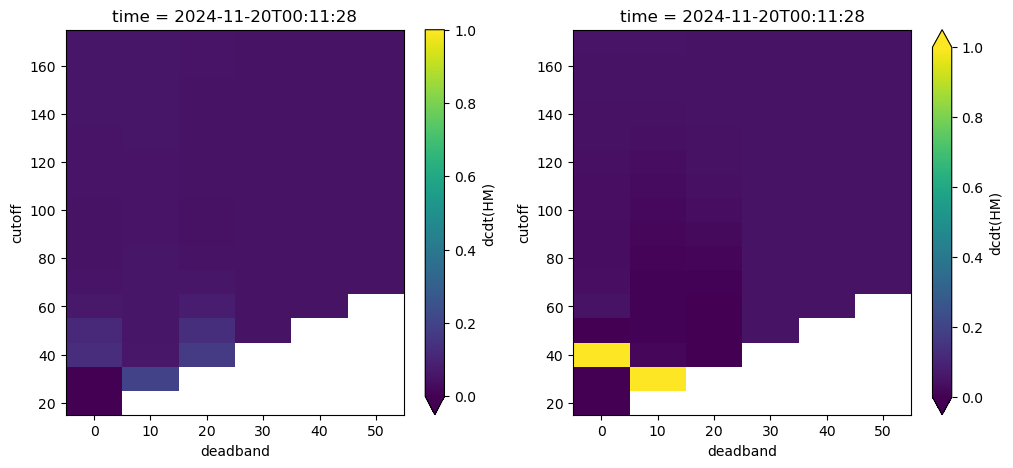

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ds.isel(time=1)['dcdt(HM)'].plot(vmin=0, vmax=1, ax=ax[0])
dsMC.isel(time=1)['dcdt(HM)'].median(dim='MC').plot(vmin=0, vmax=1, ax=ax[1])

(array([ 4.,  5., 11., 18., 16.,  9., 17., 11.,  3.,  6.]),
 array([0.04784447, 0.04794475, 0.04804503, 0.04814531, 0.04824559,
        0.04834587, 0.04844615, 0.04854643, 0.04864672, 0.048747  ,
        0.04884728]),
 <BarContainer object of 10 artists>)

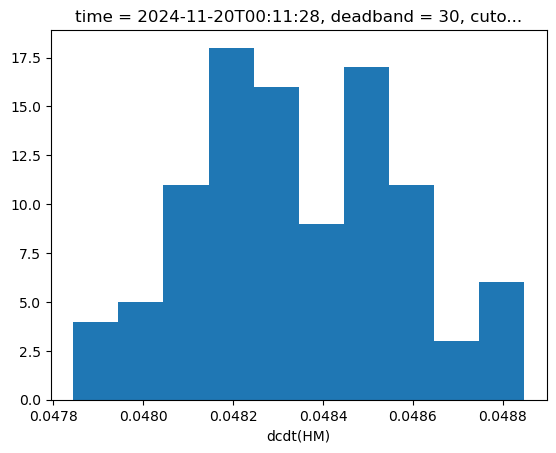

In [18]:
dsMC.isel(time=1, cutoff=5, deadband=3)['dcdt(HM)'].plot.hist()

In [7]:
expected_ds = xr.open_dataset('./output/expected_synthetic_data62_2024-11-20.nc')
expected_ds

<xarray.Dataset> Size: 365kB
Dimensions:       (time: 1620, cutoff: 16)
Coordinates:
  * time          (time) datetime64[ns] 13kB 2024-11-20T00:11:27 ... 2024-11-...
  * cutoff        (cutoff) int32 64B 20 30 40 50 60 70 ... 130 140 150 160 170
Data variables: (12/13)
    dcdt(HM)      (time, cutoff) float64 207kB ...
    deadband      (time) int64 13kB ...
    d_intensity   (time) int64 13kB ...
    d_startpoint  (time) int64 13kB ...
    add_noise     (time) bool 2kB ...
    c0            (time) int64 13kB ...
    ...            ...
    cs            (time) float64 13kB ...
    pressure      (time) float64 13kB ...
    temperature   (time) float64 13kB ...
    humidity      (time) float64 13kB ...
    area          (time) float64 13kB ...
    volume        (time) float64 13kB ...

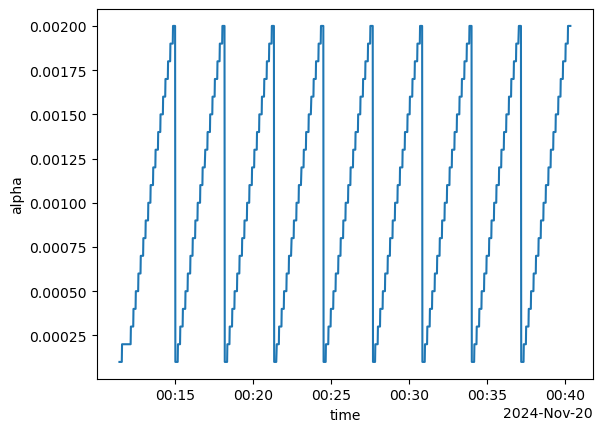

In [8]:
expected_ds['alpha'].plot()

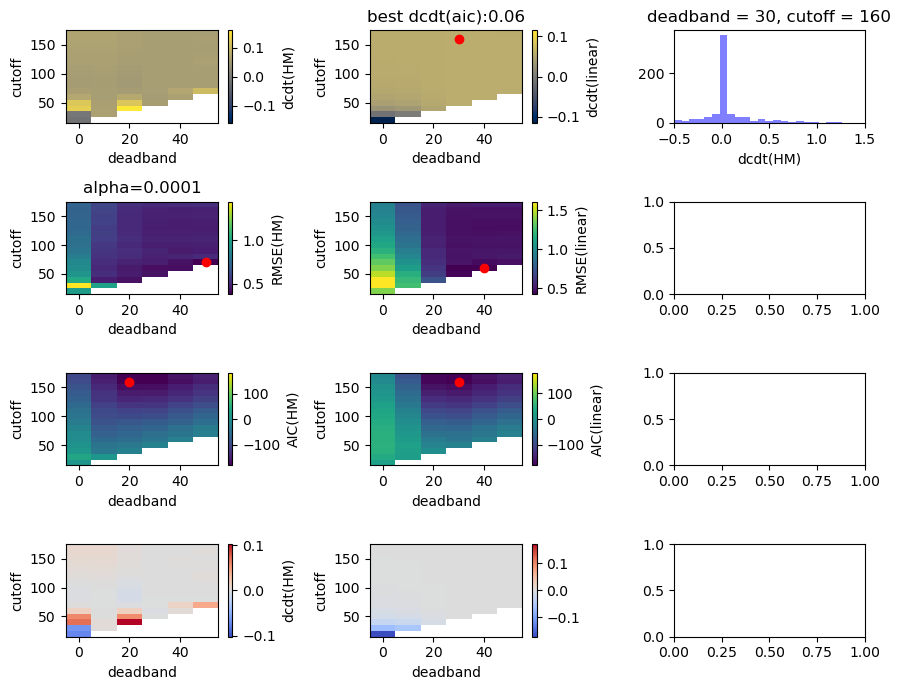

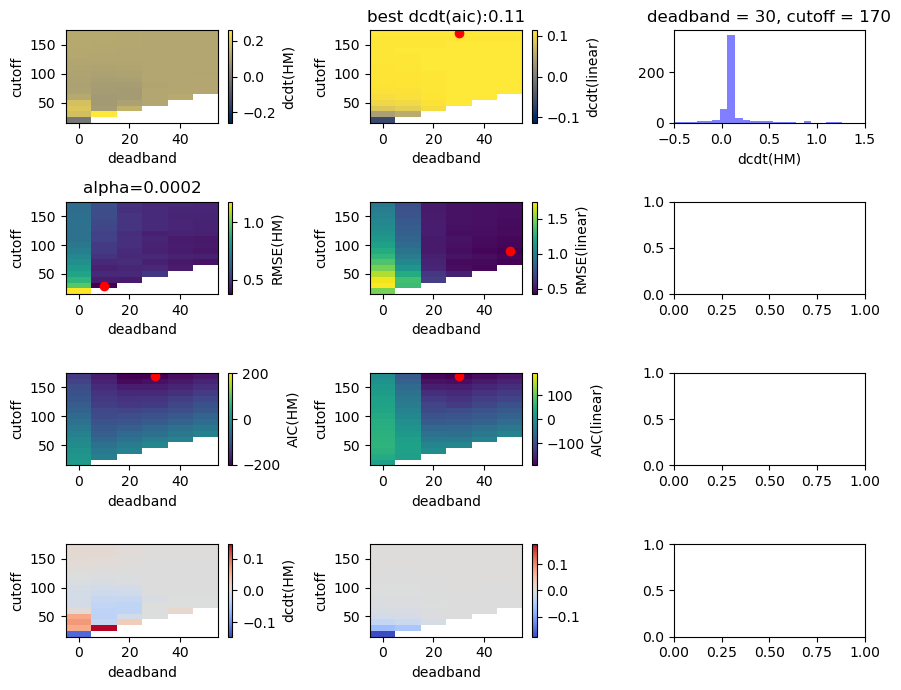

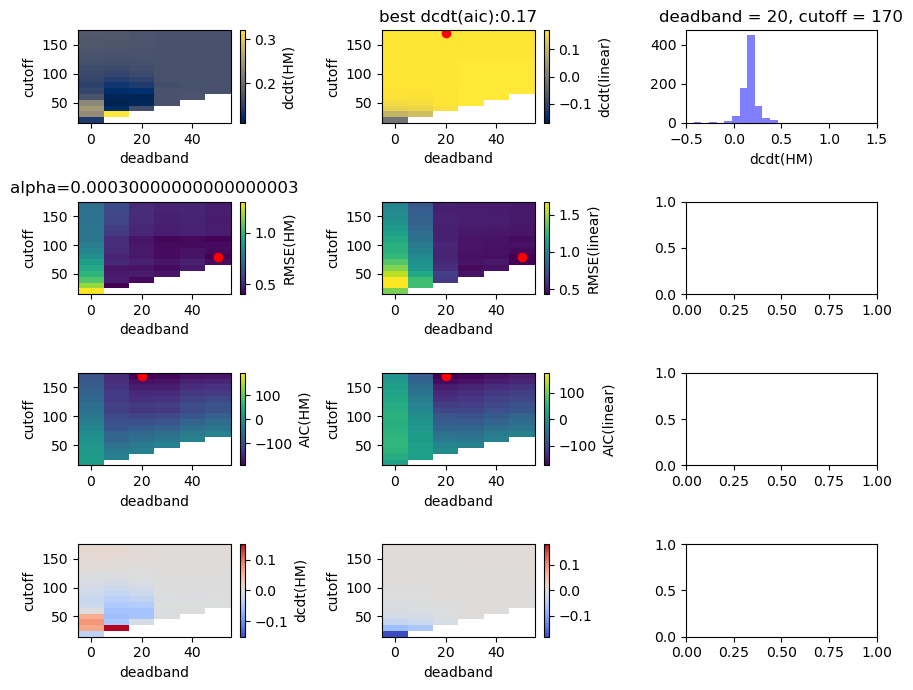

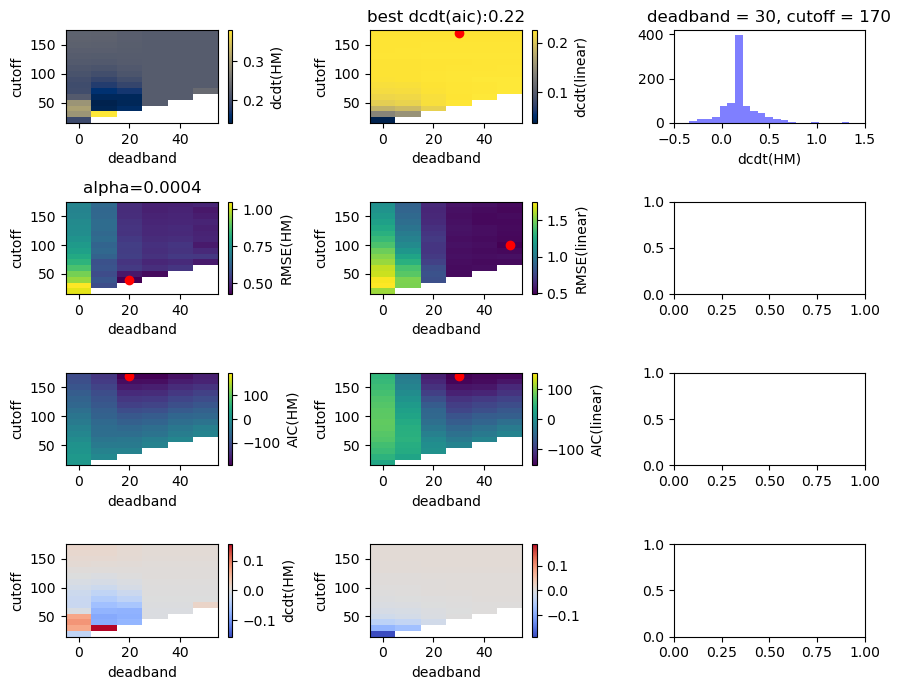

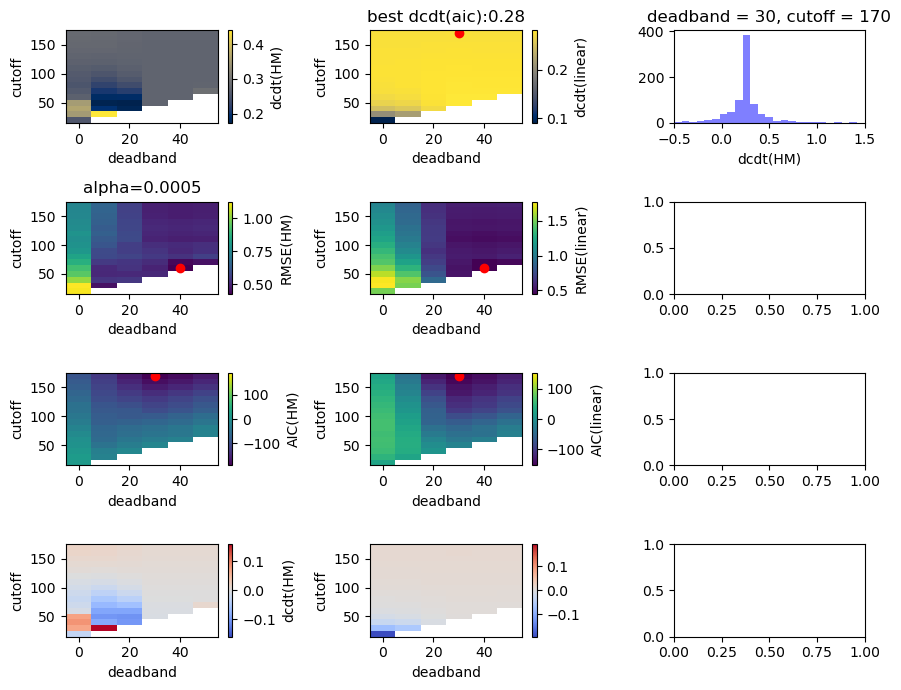

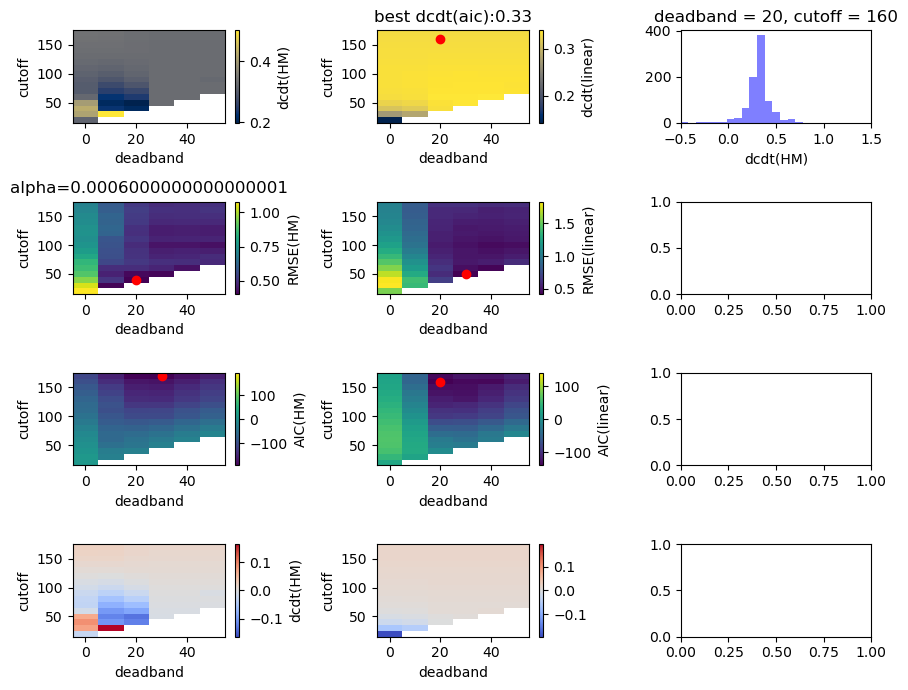

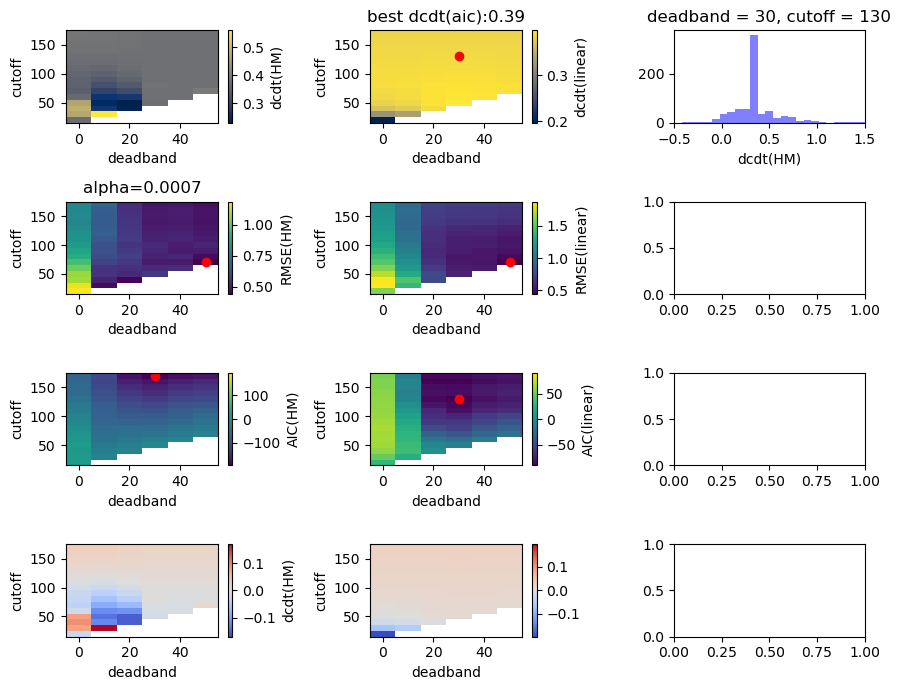

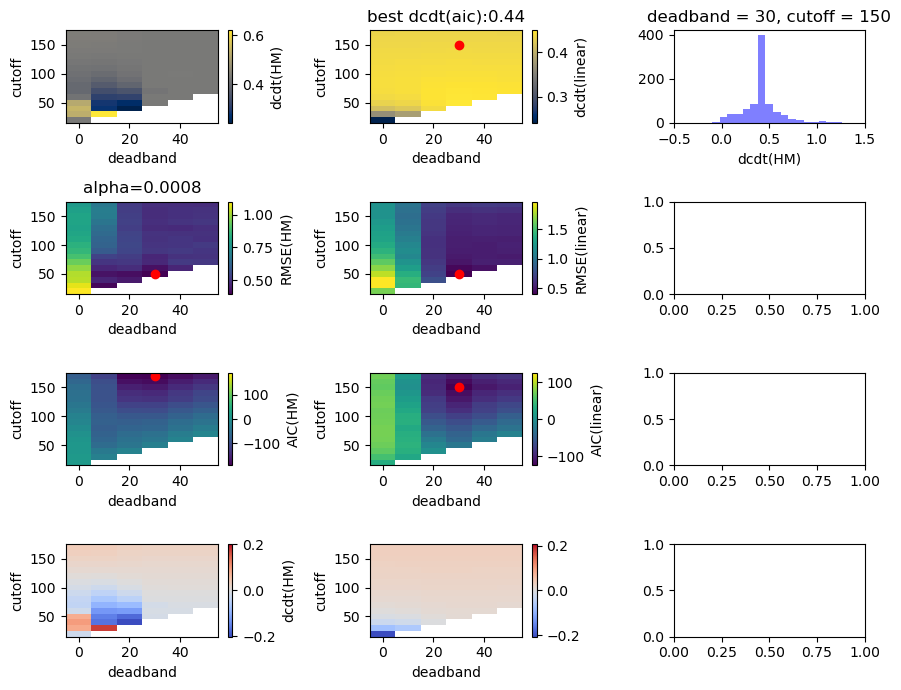

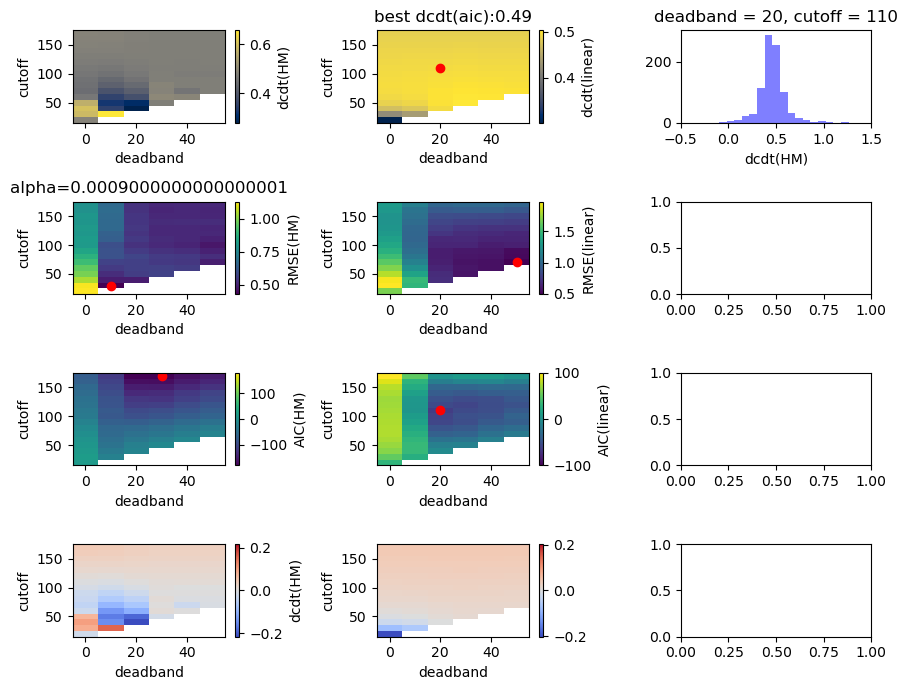

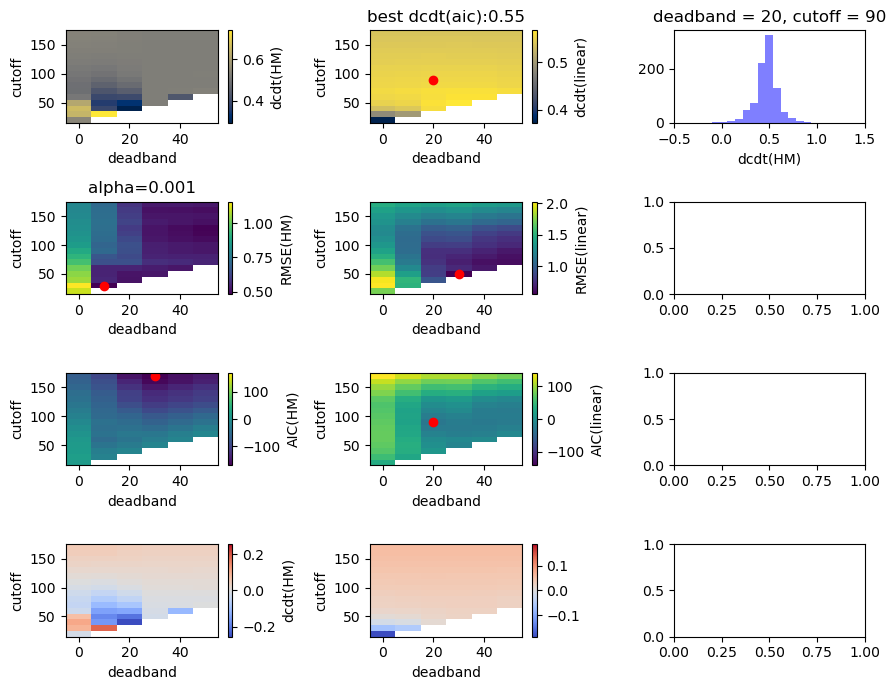

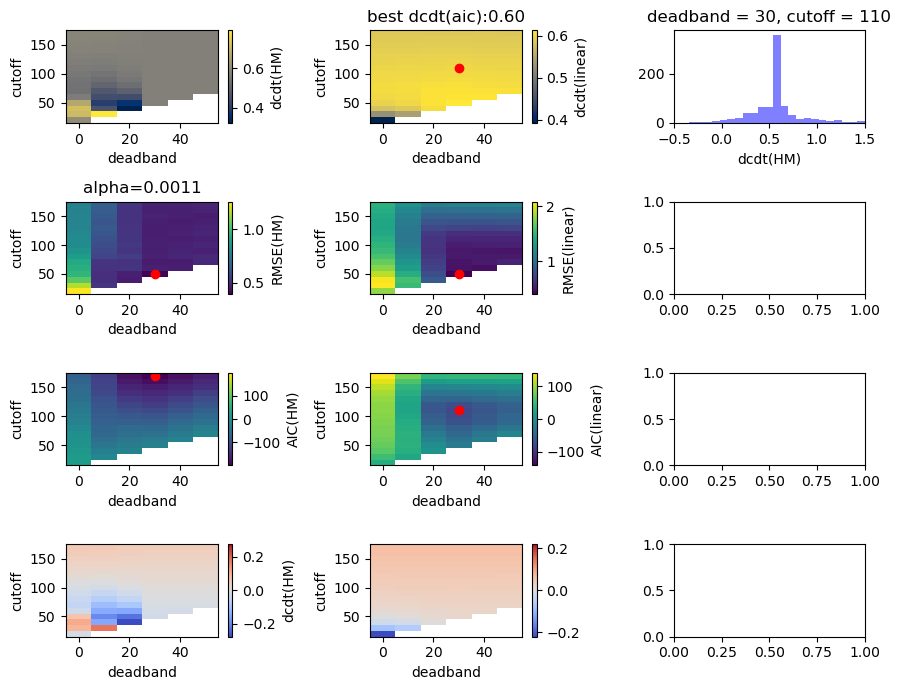

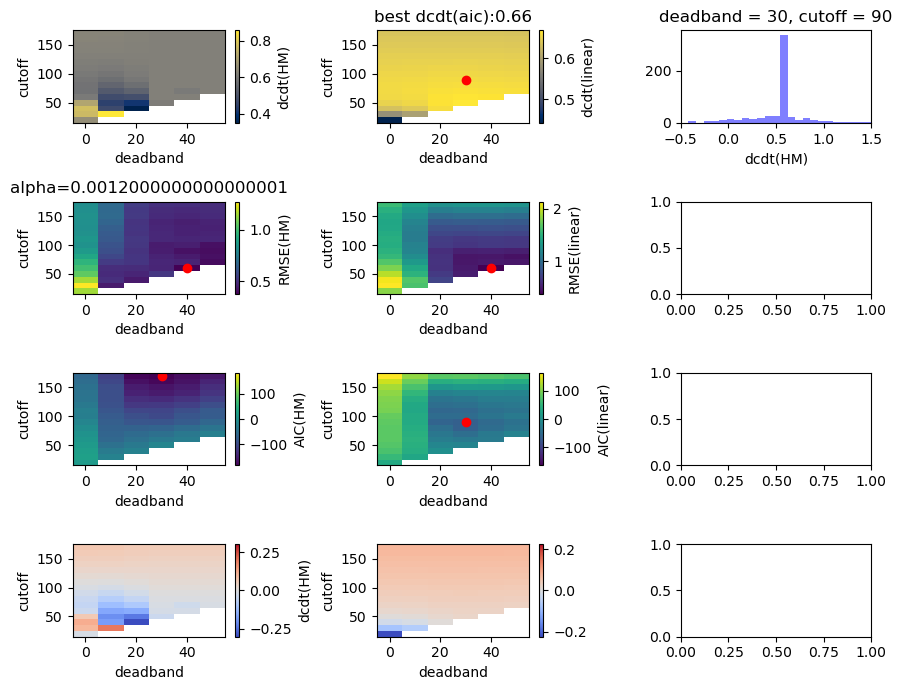

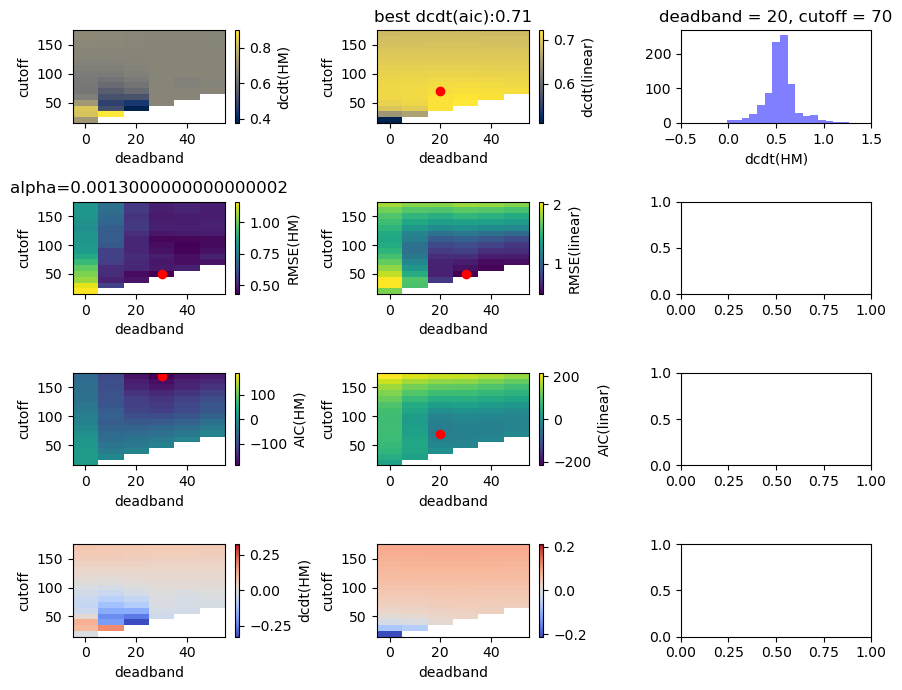

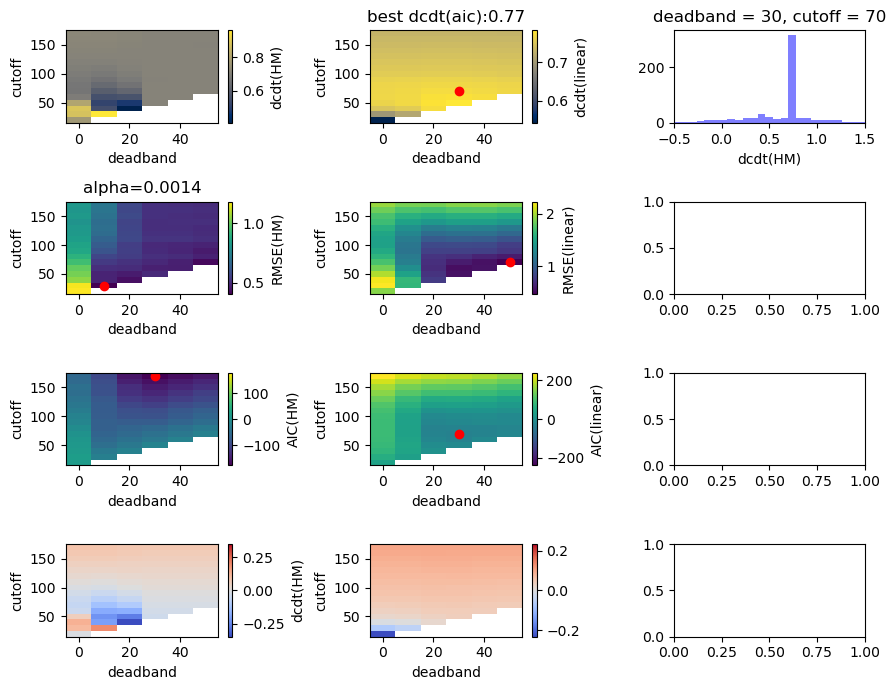

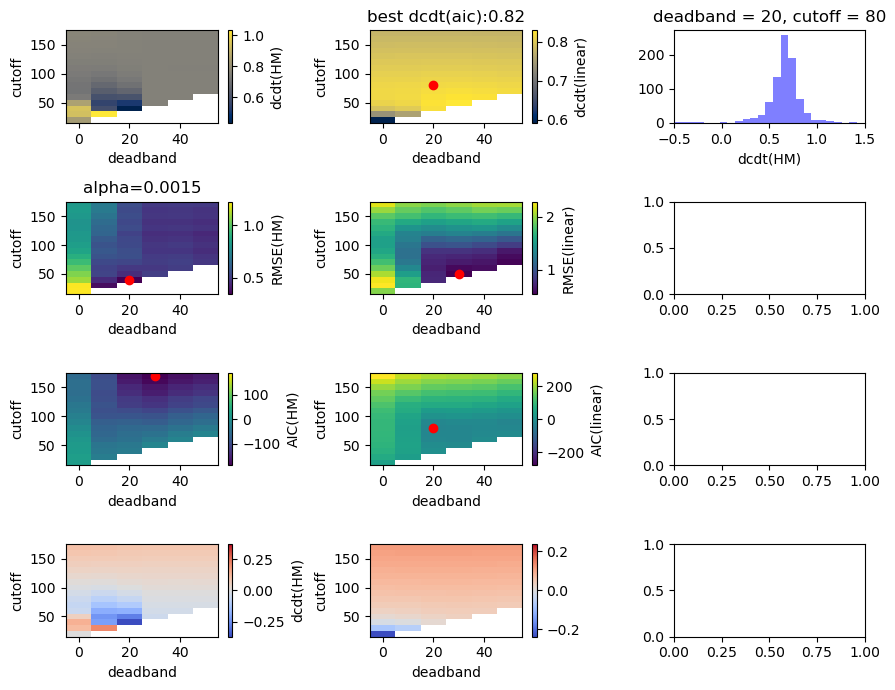

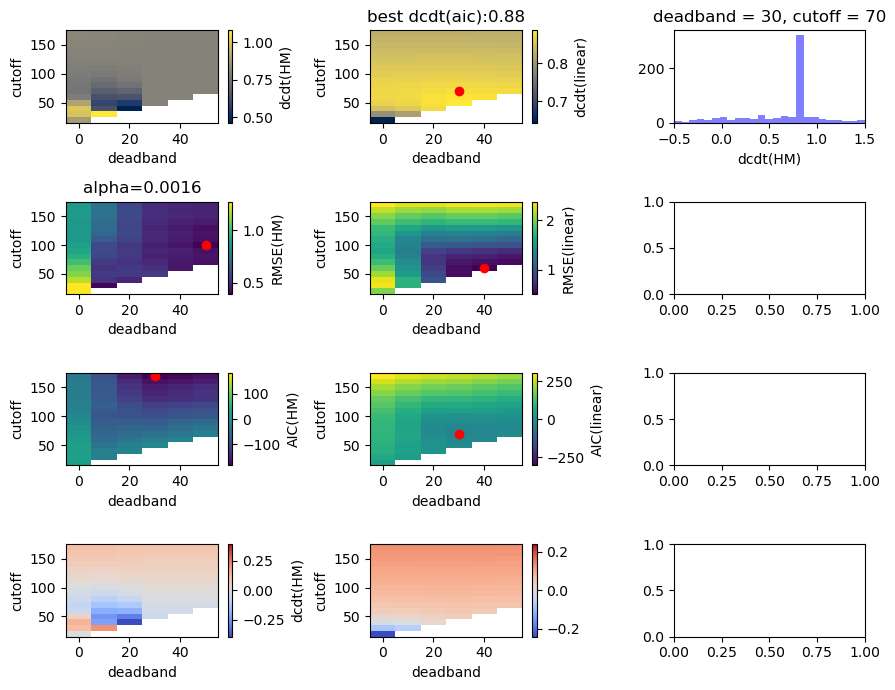

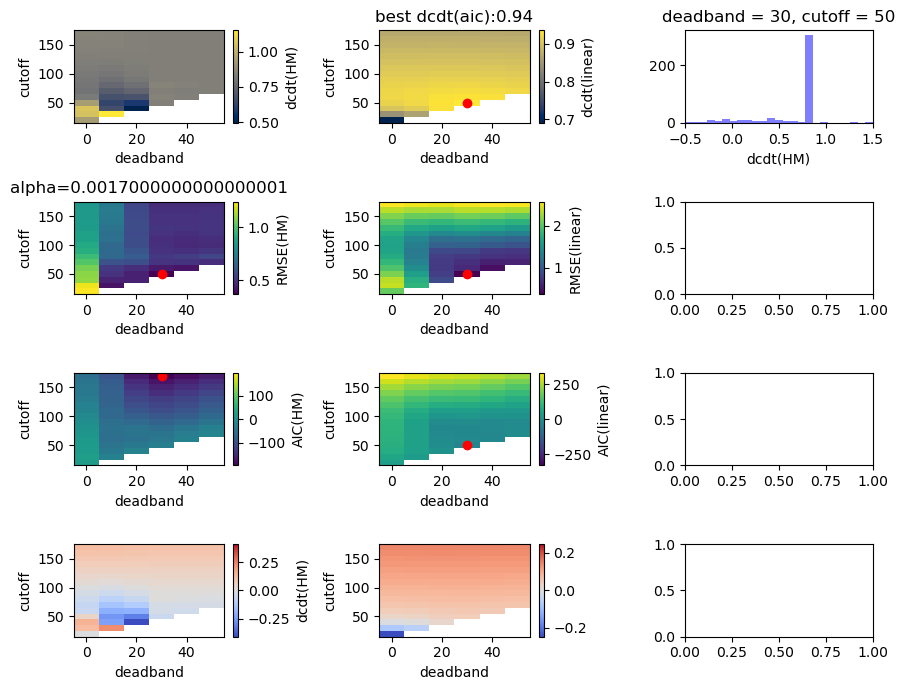

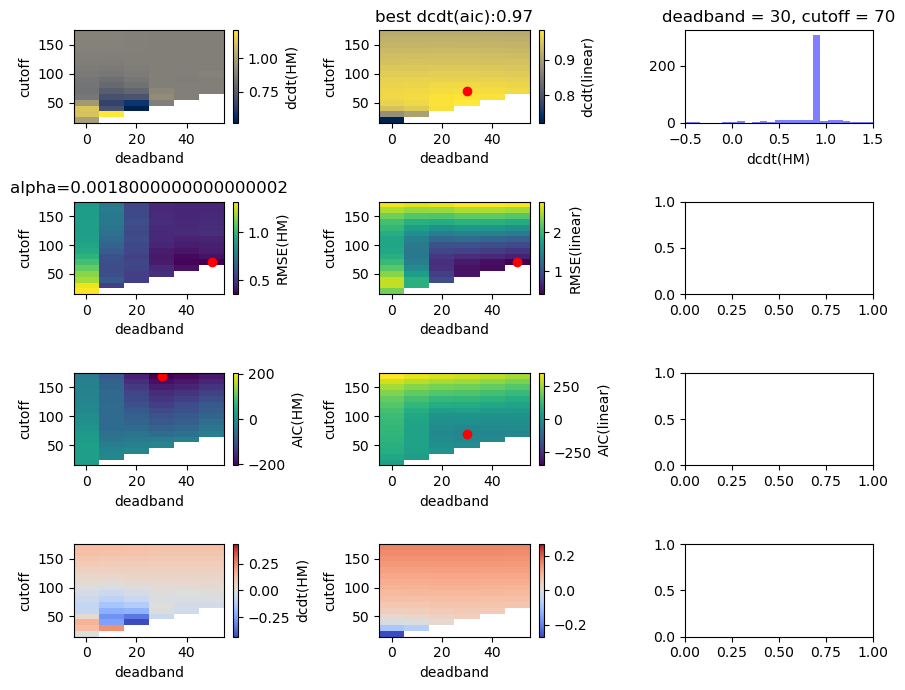

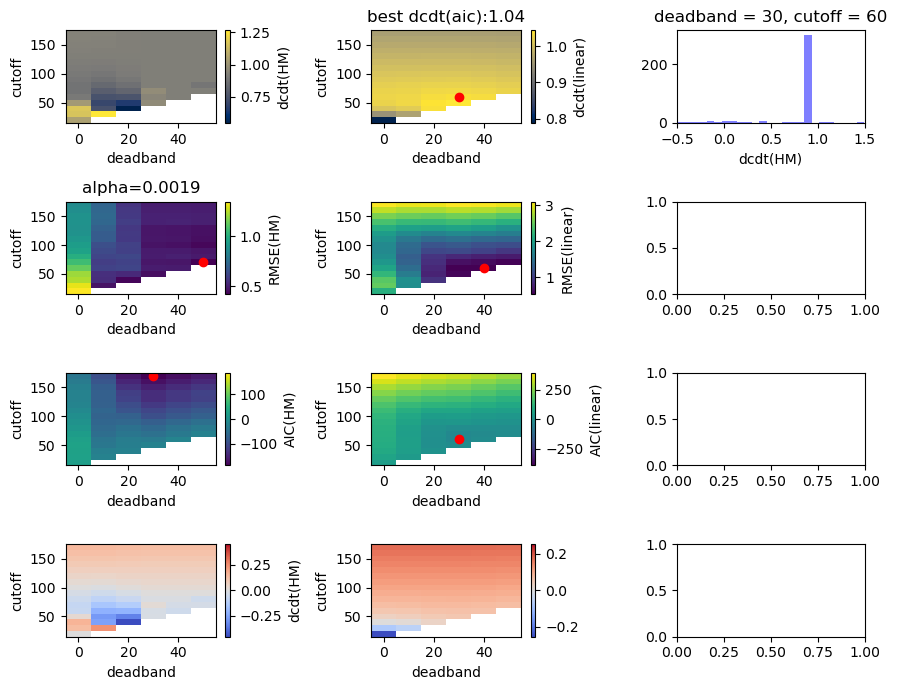

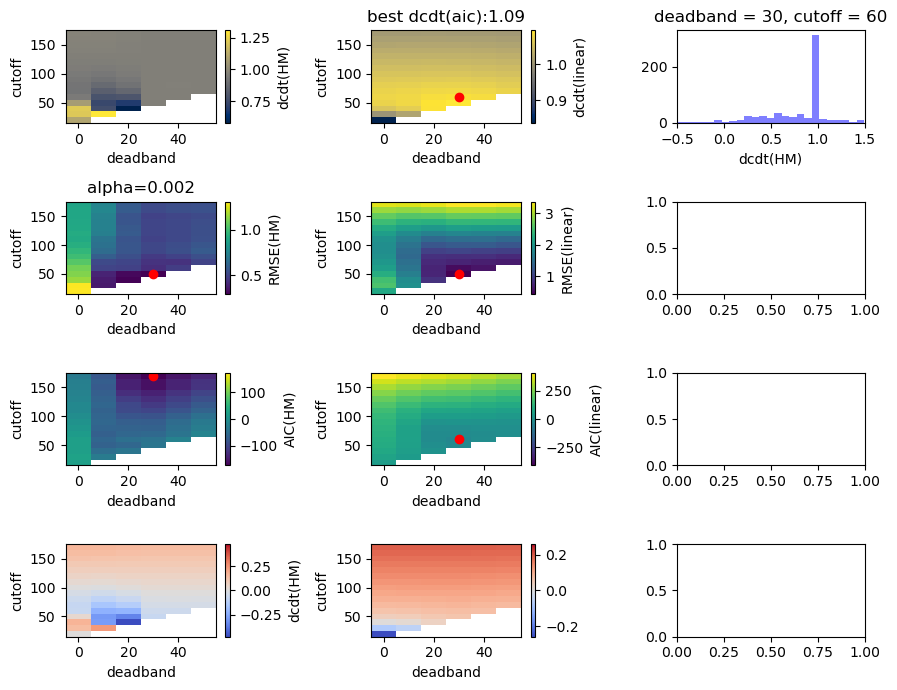

In [21]:
for alpha in np.unique(expected_ds['alpha'].values):
    # print(d_startpoint)
    # d_startpoint = 20

    fig, ax = plt.subplots(4,3, figsize=(9,7))
    
    time_selection = expected_ds.where((expected_ds['alpha'] == alpha)&(expected_ds['d_startpoint']==150), drop=True).time
    cutoff_coords, deadband_coords = ds.coords['cutoff'], ds.coords['deadband']

    ds.sel(time=time_selection)['dcdt(HM)'].median(dim=['time']).plot(ax=ax[0,0], cmap='cividis')
    ds.sel(time=time_selection)['dcdt(linear)'].median(dim=['time']).plot(ax=ax[0,1], cmap='cividis')


    ds.sel(time=time_selection)['RMSE(HM)'].median(dim=['time']).plot(ax=ax[1,0], cmap='viridis')
    ds.sel(time=time_selection)['RMSE(linear)'].median(dim=['time']).plot(ax=ax[1,1], cmap='viridis')

    ds.sel(time=time_selection)['AIC(HM)'].median(dim=['time']).plot(ax=ax[2,0], cmap='viridis')
    ds.sel(time=time_selection)['AIC(linear)'].median(dim=['time']).plot(ax=ax[2,1], cmap='viridis')

    # ax[2,0].scatter(ds.sel(time=time_selection)['AIC(HM)'].argmin(dim=['time']), ds.sel(time=time_selection)['AIC(HM)'].min(dim=['time']), color='red')
    # ax[2,0].scatter(20,100, color='red')
    
    aic_argmin_HM = ds.sel(time=time_selection)['AIC(HM)'].median(dim=['time']).argmin(dim=['cutoff', 'deadband'])
    aic_argmin_linear = ds.sel(time=time_selection)['AIC(linear)'].median(dim=['time']).argmin(dim=['cutoff', 'deadband'])

    rmse_argmin_HM = ds.sel(time=time_selection)['RMSE(HM)'].median(dim=['time']).argmin(dim=['cutoff', 'deadband'])
    rmse_argmin_linear = ds.sel(time=time_selection)['RMSE(linear)'].median(dim=['time']).argmin(dim=['cutoff', 'deadband'])

    

    ax[2,0].scatter(deadband_coords[aic_argmin_HM['deadband']], 
                    cutoff_coords[aic_argmin_HM['cutoff']], color='red')
    ax[2,1].scatter(deadband_coords[aic_argmin_linear['deadband']],
                    cutoff_coords[aic_argmin_linear['cutoff']], color='red')
    
    ax[1,0].scatter(deadband_coords[rmse_argmin_HM['deadband']],
                    cutoff_coords[rmse_argmin_HM['cutoff']], color='red')
    ax[1,1].scatter(deadband_coords[rmse_argmin_linear['deadband']],
                    cutoff_coords[rmse_argmin_linear['cutoff']], color='red')


    (ds.sel(time=time_selection)['dcdt(HM)']-expected_ds.sel(time=time_selection)['dcdt(HM)']).median(dim=['time']).plot(ax=ax[3,0], cmap='coolwarm')
    (ds.sel(time=time_selection)['dcdt(linear)']-expected_ds.sel(time=time_selection)['dcdt(HM)']).median(dim=['time']).plot(ax=ax[3,1], cmap='coolwarm')

    ax[0,1].scatter(deadband_coords[aic_argmin_linear['deadband']],
                    cutoff_coords[aic_argmin_linear['cutoff']], color='red')
    
    
    dcdt_linear_minAIC = ds.sel(time=time_selection, 
                                deadband=deadband_coords[aic_argmin_linear['deadband']],
                                cutoff=cutoff_coords[aic_argmin_linear['cutoff']])['dcdt(linear)'].median(dim=['time']).values
    
    ax[0,1].set_title(f'best dcdt(aic):{dcdt_linear_minAIC:.2f}')


    ax[1,0].set_title(f'alpha={alpha}')

    dsMC.sel(time=time_selection,
             deadband=deadband_coords[aic_argmin_linear['deadband']],
             cutoff=cutoff_coords[aic_argmin_linear['cutoff']])['dcdt(HM)'].plot.hist(range=(-0.5, 1.5), bins=25,ax=ax[0,2], alpha=0.5, color='blue')
    
    ax[0,2].set_xlim(-0.5,1.5)



    fig.tight_layout()
    fig.show()
    # break